In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))
os.getcwd()

'/home/renjie/Documents/MTech/AY1819Sem1/KE5208_SenseMakingAndInsightsDiscovery/CA'

In [2]:
from src.utils import get_dataset
from src.utils import select_data

import scipy.io as sio
from scipy.signal import resample
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical

from keras.preprocessing import sequence

from keras.models import Sequential
from keras.models import Model

from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import UpSampling1D
from keras.layers import Concatenate

from keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

/home/renjie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
os.listdir(DATA_PATH)

['Depth', 'RGB_images', 'Inertial', 'Skeleton', 'RGB', 'Depth_numpy']

In [6]:
depth_path, _,inertial_path, skeleton_path,rgb_path,_ = get_dataset(DATA_PATH)

In [7]:
activities = list(range(1,28))

In [8]:
def select_subject(d_path, subject):
    select_statement = '_s{}_'.format(subject)
    subjects = []
    for i in d_path:
        if select_statement in i:
            subjects.append(i)
    return subjects

In [9]:
def get_action_number(single_path):
    return int(single_path.split('/')[-1].split('_')[0][1:])
def get_subject_number(single_path):
    return int(single_path.split('/')[-1].split('_')[1][1:])
def get_trial_number(single_path):
    return int(single_path.split('/')[-1].split('_')[2][1:])

In [10]:
# Inertial

# train on subject 1,3,5,7
# test on subject 2,4,6,8
X_train_iner = []
Y_train_iner = []
X_test_iner = []
Y_test_iner = []

resample_len = 180

for path in inertial_path:
    if get_subject_number(path) in [1,3,5,7]:
        X_train_iner.append(path)
        Y_train_iner.append(get_action_number(path))
    else:
        X_test_iner.append(path)
        Y_test_iner.append(get_action_number(path))

# X_train_iner = [pad_len_inertial(sio.loadmat(x)['d_iner']) for x in X_train_iner]
# X_test_iner = [pad_len_inertial(sio.loadmat(x)['d_iner']) for x in X_test_iner]

X_train_iner = [resample(sio.loadmat(x)['d_iner'], resample_len) for x in X_train_iner]
X_test_iner = [resample(sio.loadmat(x)['d_iner'], resample_len) for x in X_test_iner]


X_train_iner = np.array(X_train_iner)
X_test_iner = np.array(X_test_iner)

Y_train_iner = to_categorical(np.array(Y_train_iner) - 1)
Y_test_iner = to_categorical(np.array(Y_test_iner) - 1)

##################
# normalize data #
##################

# X_train_iner[:,:,3:] = X_train_iner[:,:,3:]/ max(X_train_iner[:,:,3:].max(), abs(X_train_iner[:,:,3:].min()))
# X_train_iner[:,:,:3] = X_train_iner[:,:,:3]/ max(X_train_iner[:,:,:3].max(), abs(X_train_iner[:,:,:3].min()))

# X_test_iner[:,:,3:] = X_test_iner[:,:,3:]/ max(X_test_iner[:,:,3:].max(), abs(X_test_iner[:,:,3:].min()))
# X_test_iner[:,:,:3] = X_test_iner[:,:,:3]/ max(X_test_iner[:,:,:3].max(), abs(X_test_iner[:,:,:3].min()))

X_train_iner.shape, Y_train_iner.shape, X_test_iner.shape, Y_test_iner.shape

((431, 180, 6), (431, 27), (430, 180, 6), (430, 27))

In [11]:
# Skel 
# train on subject 1,3,5,7
# test on subject 2,4,6,8
X_train_skel = []
Y_train_skel = []
X_test_skel = []
Y_test_skel = []

resample_len = 180

for path in skeleton_path:
    if get_subject_number(path) in [1,3,5,7]:
        X_train_skel.append(path)
        Y_train_skel.append(get_action_number(path))
    else:
        X_test_skel.append(path)
        Y_test_skel.append(get_action_number(path))

# X_train_skel = [pad_len_inertial(sio.loadmat(x)['d_iner']) for x in X_train_skel]
# X_test_skel = [pad_len_inertial(sio.loadmat(x)['d_iner']) for x in X_test_skel]

X_train_skel = [np.reshape(resample(sio.loadmat(x)['d_skel'], resample_len, axis = -1), (60,180)) for x in X_train_skel]
X_test_skel = [np.reshape(resample(sio.loadmat(x)['d_skel'], resample_len, axis = -1), (60,180)) for x in X_test_skel]


X_train_skel = np.array(X_train_skel)
X_test_skel = np.array(X_test_skel)

X_train_skel = np.swapaxes(X_train_skel, 1,2)
X_test_skel = np.swapaxes(X_test_skel, 1,2)

Y_train_skel = to_categorical(np.array(Y_train_skel) - 1)
Y_test_skel = to_categorical(np.array(Y_test_skel) - 1)

X_train_skel.shape, Y_train_skel.shape, X_test_skel.shape, Y_test_skel.shape

((431, 180, 60), (431, 27), (430, 180, 60), (430, 27))

In [12]:
X_train = np.concatenate((X_train_iner, X_train_skel), axis = -1)
X_test = np.concatenate((X_test_iner, X_test_skel), axis = -1)

Y_train = Y_train_iner
Y_test = Y_test_iner

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((431, 180, 66), (431, 27), (430, 180, 66), (430, 27))

# Model

In [13]:
def conv_LSTM2():
    # Create the model
    np.random.seed(7)
    optimizer = Adam(lr=1e-4)
    model = Sequential(name = 'conv_LSTM2')
    model.add(Conv1D(16,
                     3,
                     padding='same',
                     activation='relu',
                     strides=1,
                     kernel_initializer = 'glorot_uniform',
                    input_shape=(180, 66)))
    model.add(Conv1D(32,
                     3,
                     padding='same',
                     activation='relu',
                     strides=1,
                    kernel_initializer = 'glorot_uniform'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64,
                     3,
                     padding='same',
                     activation='relu',
                     strides=1,
                    kernel_initializer = 'glorot_uniform'))
    model.add(Conv1D(128,
                     3,
                     padding='same',
                     activation='relu',
                     strides=1,
                    kernel_initializer = 'glorot_uniform'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(LSTM(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(len(activities), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model

In [22]:
def UNet_LSTM():
    optimizer = Adam(lr=1e-4)
    inputs = Input((180, 66))
  
  # encoding phase
    conv1 = Conv1D(32,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(inputs)
    conv2 = Conv1D(32,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(conv1)
    pool1 = MaxPooling1D(pool_size = 2)(conv2) # 90

    conv3 = Conv1D(64,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(pool1)
    conv4 = Conv1D(64,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(conv3)
    pool2 = MaxPooling1D(pool_size = 2)(conv4) # 45

    #   conv5 = Conv1D(128,
    #                  3,
    #                  padding='same',
    #                  activation='relu',
    #                  strides=1,
    #                  kernel_initializer = 'glorot_uniform')(pool2)
    #   conv6 = Conv1D(128,
    #                  3,
    #                  padding='same',
    #                  activation='relu',
    #                  strides=1,
    #                  kernel_initializer = 'glorot_uniform')(conv5)
    #   pool3 = MaxPooling1D(pool_size = 2)(conv6) # 

    # middle phase
    conv7 = Conv1D(128,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(pool2)
    conv8 = Conv1D(128,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(conv7)
    drop1 = Dropout(0.5)(conv8)

    # decoding phase
    #   up1 = Conv1D(128,
    #                  2,
    #                  padding='same',
    #                  activation='relu',
    #                  strides=1,
    #                  kernel_initializer = 'glorot_uniform')(UpSampling1D(size = 2)(drop1))
    #   concat1 = Concatenate(axis=-1)([conv6, up1])
    #   conv9 = Conv1D(128,
    #                  3,
    #                  padding='same',
    #                  activation='relu',
    #                  strides=1,
    #                  kernel_initializer = 'glorot_uniform')(UpSampling1D(size = 2)(concat1))
    #   conv10 = Conv1D(128,
    #                  3,
    #                  padding='same',
    #                  activation='relu',
    #                  strides=1,
    #                  kernel_initializer = 'glorot_uniform')(UpSampling1D(size = 2)(conv9))

    up2 = Conv1D(64,
               2,
               padding='same',
               activation='relu',
               strides=1,
               kernel_initializer = 'glorot_uniform')(UpSampling1D(size = 2)(drop1))
    concat2 = Concatenate(axis=-1)([conv4, up2])
    conv11 = Conv1D(64,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(concat2)
    conv12 = Conv1D(64,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(conv11)

    up3 = Conv1D(32,
               2,
               padding='same',
               activation='relu',
               strides=1,
               kernel_initializer = 'glorot_uniform')(UpSampling1D(size = 2)(conv12))
    concat3 = Concatenate(axis=-1)([conv2, up3])
    conv13 = Conv1D(32,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(concat3)
    conv14 = Conv1D(128,
                 3,
                 padding='same',
                 activation='relu',
                 strides=1,
                 kernel_initializer = 'glorot_uniform')(conv13)

    # classification Level
    lstm1 = LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(conv14)
    lstm2 = LSTM(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(lstm1)
    flat1 = Flatten()(lstm2)

    dense1 = Dense(len(activities), activation='softmax')(flat1)

    model = Model(input = inputs, output = dense1, name = 'UNet_LSTM')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model


In [23]:
# model = conv_LSTM2()
model = UNet_LSTM()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 66)      0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 180, 32)      6368        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 180, 32)      3104        conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 90, 32)       0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (

/home/renjie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="UNet_LSTM", inputs=Tensor("in..., outputs=Tensor("de...)`


In [24]:
LOG_DIR = os.path.join(os.getcwd(), 'logs')
tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model.name + \
            '-{epoch:02d}-{loss:.2f}.hdf5'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='val_acc', save_best_only=True, save_weights_only=True, mode='auto', period=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=10)

In [25]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=3, validation_data = (X_test, Y_test), callbacks=[tb, chkpt, early_stop])

Train on 431 samples, validate on 430 samples
Epoch 1/50
431/431 [==============================] - 353s 819ms/step - loss: 3.1352 - acc: 0.1369 - val_loss: 2.0074 - val_acc: 0.5209
Epoch 2/50
431/431 [==============================] - 376s 872ms/step - loss: 1.8198 - acc: 0.4872 - val_loss: 1.2760 - val_acc: 0.6256
Epoch 3/50
431/431 [==============================] - 399s 925ms/step - loss: 0.9910 - acc: 0.7007 - val_loss: 1.1047 - val_acc: 0.6814
Epoch 4/50
431/431 [==============================] - 394s 915ms/step - loss: 0.6082 - acc: 0.8074 - val_loss: 1.1402 - val_acc: 0.7140
Epoch 5/50
431/431 [==============================] - 437s 1s/step - loss: 0.4355 - acc: 0.8608 - val_loss: 1.2219 - val_acc: 0.6791
Epoch 6/50
431/431 [==============================] - 413s 957ms/step - loss: 0.3727 - acc: 0.8794 - val_loss: 1.2195 - val_acc: 0.7372
Epoch 7/50
431/431 [==============================] - 404s 938ms/step - loss: 0.3043 - acc: 0.9165 - val_loss: 1.1649 - val_acc: 0.7419
Epoch

# Evaluation

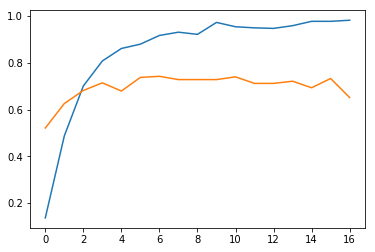

<Figure size 432x288 with 0 Axes>

In [26]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, 'C0')
plt.plot(val_acc, 'C1')
plt.show()
plt.savefig('UNet_LSTM_acc_plot_iner_skel.png')

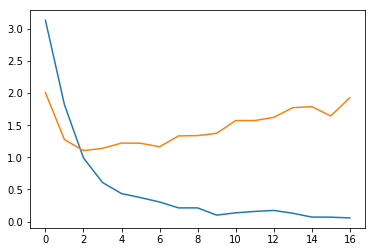

<Figure size 432x288 with 0 Axes>

In [27]:
train_acc = history.history['loss']
val_acc = history.history['val_loss']
plt.plot(train_acc, 'C0')
plt.plot(val_acc, 'C1')
plt.show()
plt.savefig('UNet_LSTM_loss_plot_iner_skel.png')

In [34]:
# ensemble
model_1 = conv_LSTM2()
model_2 = UNet_LSTM()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 180, 16)           3184      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 180, 32)           1568      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 90, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 90, 64)            6208      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 90, 128)           24704     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 45, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 45, 256)           394240    
__________

/home/renjie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="UNet_LSTM", inputs=Tensor("in..., outputs=Tensor("de...)`


In [35]:
model_1.load_weights('weights/combined_iner_skel/conv_LSTM2-13-0.27.hdf5')
model_2.load_weights('weights/combined_iner_skel/UNet_LSTM-07-0.30.hdf5')

In [29]:
model.evaluate(X_train, Y_train)

431/431 [==============================] - 12s 28ms/step


[0.04359209534237831, 0.988399071925754]

In [30]:
model.evaluate(X_test, Y_test)

430/430 [==============================] - 19s 43ms/step


[1.164892672660739, 0.74186046539351]

In [43]:
pred_1 = np.argmax(model.predict(X_test), axis = -1)

# Ensemble
# pred_1 = np.argmax((model_1.predict(X_test) + model_2.predict(X_test))/2,axis = -1)

In [32]:
class_labels = ['swipe to the left',
               'swipe to the right',
               'wave',
               'front clap',
               'throw',
               'cross arms',
               'basketball shoot',
               'draw x',
               'draw circle (CW)',
               'draw circle (CCW)',
               'draw triangle',
               'bowling',
               'boxing',
               'baseball swing',
               'tennis swing',
               'arm curl',
               'tennis serve',
               'two hand push',
               'knock door',
               'catch',
               'pick and throw',
               'jogging',
               'walking',
               'sit to stand',
               'stand to sit',
               'forward lunge',
               'squat']

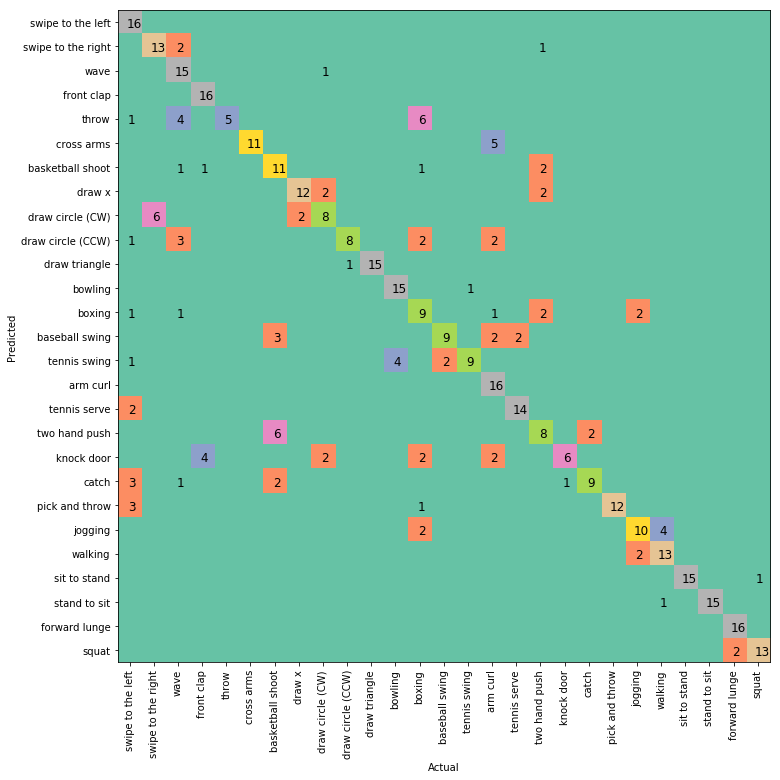

In [44]:
confusion_1 = confusion_matrix(np.argmax(Y_test, axis = -1), pred_1)
NUM_LABELS = 27

f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(27)))
axes.set_xticks(list(range(27)))
plt.imshow(confusion_1, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion_1):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

f.savefig('UNet_lstm_confusion_matrix_iner_skel.png')

In [42]:
(pred_1 == np.argmax(Y_test,axis = -1)).sum()/ pred_1.size

0.8209302325581396